In [ ]:
# default_exp startup

## Dataset

made using **abalajiaus/oct_ca:latest-fastai-skl-ski-fire-onnx-mlflow**

In [ ]:
#exports
from fastai.vision import *
import mlflow
import model
import pandas as pd
import mlflow.pytorch as MYPY

In [ ]:
#exports
def saveDictToConfigJSON(dictiontary, name):
    with open('/workspace/oct_ca_seg/oct/configs/'+ name, 'w') as file:
        json.dump(dictiontary, file)

In [ ]:
#exports
def loadConfigJSONToDict(fn):
    with open('/workspace/oct_ca_seg/oct/configs/'+ fn, 'r') as file:
        config = json.load(file)
        return config

In [ ]:
#exports
class DeepConfig():
    def __init__(self, config_dict):
        
        self.config_dict = config_dict
        
        for k,v in self.config_dict.items():
            setattr(self, k, DeepConfig(v) if isinstance(v, dict) else v)

In [ ]:
config_test = loadConfigJSONToDict('init_config.json')

In [ ]:
config = DeepConfig(config_test)

In [ ]:
config.DATSET.bs = 1
config.MODEL.dims1 = 8
config.MODEL.dims2 = 12
config.MODEL.dims3 = 16
config.MODEL.maps1 = 2
config.MODEL.maps2 = 8
config.MODEL.maps3 = 12
config.MODEL.f1dims = 8
config.MODEL.f2dims = 12
config.MODEL.f1maps = 2
config.MODEL.f2maps = 2 #this should be number of classes. background, lumen => 2 etc.
config.LEARNER.lr = 0.01

In [ ]:
cocodata_path = Path('/workspace/oct_ca_seg/COCOdata/')
train_path = cocodata_path/'train/images'
valid_path = cocodata_path/'valid/images'
test_path = cocodata_path/'test/images'

In [ ]:
anno_name = 'medium_set_annotations.json' #or 'annotations.json' for full set

In [ ]:
train_anno = train_path/anno_name
valid_anno = valid_path/anno_name
test_anno = test_path/anno_name

In [ ]:
trainData = ImageList.from_folder(train_path)
validData = ImageList.from_folder(valid_path)
testData = ImageList.from_folder(test_path)

In [ ]:
#export
binify = lambda x : x.point(lambda p: float(p>100.))#.point(lambda p: float(p))

In [ ]:
fn = get_image_files(cocodata_path/'train/labels', recurse=True)[10]

In [ ]:
labal = open_mask(fn, after_open=binify, convert_mode='L')

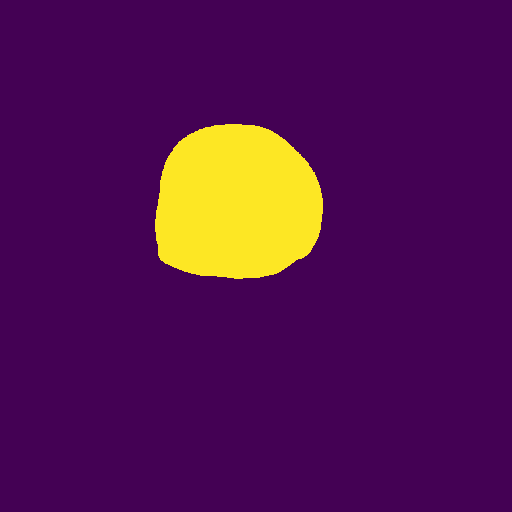

In [ ]:
labal

In [ ]:
labal.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

(array([240817.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,  21327.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

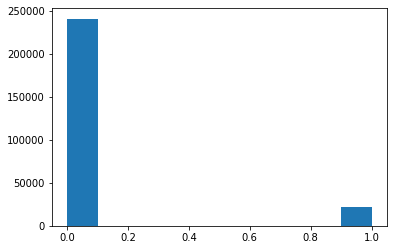

In [ ]:
plt.hist(labal.data.flatten())

In [ ]:
#export
class SegCustomLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, after_open=binify, convert_mode='L')

In [ ]:
#export
class SegCustomItemList(SegmentationItemList):
    _label_cls = SegCustomLabelList

In [ ]:
src = SegCustomItemList.from_folder(cocodata_path, recurse=True, extensions='.jpg').filter_by_func(lambda fname: Path(fname).parent.name == 'images', ).split_by_folder('train', 'valid')

In [ ]:
codes = np.loadtxt(cocodata_path/'codes.txt', dtype=str)

In [ ]:
fn_get_y = lambda image_name: Path(image_name).parent.parent/('labels/'+Path(image_name).name)

In [ ]:
src.label_from_func(fn_get_y, classes=codes)

LabelLists;

Train: LabelList (8502 items)
x: SegCustomItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegCustomLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /workspace/oct_ca_seg/COCOdata;

Valid: LabelList (2499 items)
x: SegCustomItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegCustomLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /workspace/oct_ca_seg/COCOdata;

Test: None

In [ ]:
tfms=get_transforms()[0].append(TfmPixel(to_float))

In [ ]:
src.transform(tfms, size=256, tfm_y=True)

LabelLists;

Train: LabelList (8502 items)
x: SegCustomItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegCustomLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /workspace/oct_ca_seg/COCOdata;

Valid: LabelList (2499 items)
x: SegCustomItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegCustomLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /workspace/oct_ca_seg/COCOdata;

Test: None

In [ ]:
src.train.y[0].data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

In [ ]:
bs = config.DATSET.bs

In [ ]:
data = src.databunch(bs=bs, val_bs=bs*2)

In [ ]:
#data.transform(get_transforms()[0], tfm_y=True)

In [ ]:
stats = [torch.tensor([0.2190, 0.1984, 0.1928]), torch.tensor([0.0645, 0.0473, 0.0434])]

In [ ]:
data.normalize(stats)

ImageDataBunch;

Train: LabelList (8502 items)
x: SegCustomItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegCustomLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /workspace/oct_ca_seg/COCOdata;

Valid: LabelList (2499 items)
x: SegCustomItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegCustomLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /workspace/oct_ca_seg/COCOdata;

Test: None

In [ ]:
src.train.y[0].data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

In [ ]:
torch.argmax(src.train.x[0].data, 0, keepdim=True).size()

torch.Size([1, 512, 512])

In [ ]:
#data.transform(tfms[0], tfm_y=True, size=(256, 256))

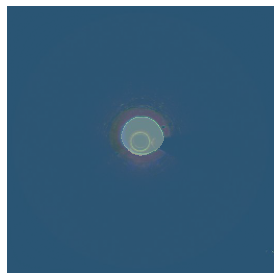

In [ ]:
data.show_batch(10, ds_type=DatasetType.Train)

In [ ]:
data.one_batch()

(tensor([[[[0.1529, 0.1529, 0.1529,  ..., 0.1804, 0.1530, 0.1294],
           [0.1529, 0.1529, 0.1529,  ..., 0.1686, 0.1490, 0.1294],
           [0.1529, 0.1529, 0.1529,  ..., 0.1490, 0.1412, 0.1373],
           ...,
           [0.1529, 0.1529, 0.1529,  ..., 0.1529, 0.1529, 0.1529],
           [0.1529, 0.1529, 0.1529,  ..., 0.1529, 0.1529, 0.1529],
           [0.1529, 0.1529, 0.1529,  ..., 0.1529, 0.1529, 0.1529]],
 
          [[0.1529, 0.1529, 0.1529,  ..., 0.1373, 0.1529, 0.1647],
           [0.1529, 0.1529, 0.1529,  ..., 0.1451, 0.1569, 0.1647],
           [0.1529, 0.1529, 0.1529,  ..., 0.1608, 0.1607, 0.1608],
           ...,
           [0.1529, 0.1529, 0.1529,  ..., 0.1529, 0.1529, 0.1529],
           [0.1529, 0.1529, 0.1529,  ..., 0.1529, 0.1529, 0.1529],
           [0.1529, 0.1529, 0.1529,  ..., 0.1529, 0.1529, 0.1529]],
 
          [[0.1529, 0.1529, 0.1529,  ..., 0.1608, 0.1608, 0.1608],
           [0.1529, 0.1529, 0.1529,  ..., 0.1450, 0.1529, 0.1529],
           [0.1529, 0.15

## Metrics

In [ ]:
#export
def sens(c, l):
    n_targs=l.size()[0]
    c = c.argmax(dim=1).view(n_targs,-1).float()
    l = l.view(n_targs, -1).float()
    inter = torch.sum(c*l, dim=(1))
    union = torch.sum(c, dim=(1)) + torch.sum(l, dim=1) - inter
    return (inter/union).mean()

def spec(c, l):
    n_targs=l.size()[0]
    c = c.argmax(dim=1).view(n_targs,-1).float()
    l = l.view(n_targs, -1).float()
    c=1-c
    l=1-l
    inter = torch.sum(c*l, dim=(1))
    union = torch.sum(c, dim=(1)) + torch.sum(l, dim=1) - inter
    return (inter/union).mean()

'''def acc(c, l):
    n_targs=l.size()[0]
    c = c.argmax(dim=1).view(n_targs,-1)
    l = l.view(n_targs, -1).float()
    return torch.sum(c,dim=(1)) / l.size()[-1]'''

def acc(c, l):
    n_targs=l.size()[0]
    c = c.argmax(dim=1).view(n_targs,-1)
    l = l.argmax(dim=1).view(n_targs,-1)
    c = torch.sum(torch.eq(c,l).float(),dim=1)
    return (c/l.size()[-1]).mean()


class Dice_Loss(torch.nn.Module):
    """This is a custom Dice Similarity Coefficient loss function that we use 
    to the accuracy of the segmentation. it is defined as ;
    DSC = 2 * (pred /intersect label) / (pred /union label) for the losss we use
    1- DSC so gradient descent leads to better outputs."""
    def __init__(self, weight=None, size_average=False):
        super(Dice_Loss, self).__init__()
        
    def forward(self, pred, label):
        label = label.float()
        smooth = 1.              #helps with backprop
        intersection = torch.sum(pred * label)
        union = torch.sum(pred) + torch.sum(label)
        loss = (2. * intersection + smooth) / (union + smooth)
        #return 1-loss because we want to minimise dissimilarity
        return 1 - (loss)

def my_Dice_Loss(pred, label):
        pred = torch.argmax(pred, dim=0,keepdim=True)
        label = label.float()
        smooth = 1.              #helps with backprop
        intersection = torch.sum(pred * label)
        union = torch.sum(pred) + torch.sum(label)
        loss = (2. * intersection + smooth) / (union + smooth)
        #return 1-loss because we want to minimise dissimilarity
        return 1 - (loss)

## Model

### Deep Cap

the way configs were originally set up needs some help to work here. just made a little recursive config class

In [ ]:
from model import CapsNet

note these functions have the absolute path in the docker image to teh configs save dir

In [ ]:
torch.cuda.is_available()

True

In [ ]:
#saveDictToConfigJSON(config.config_dict, 'config_test_save.json')

In [ ]:
capsnet = CapsNet(config.MODEL).cuda()

In [ ]:
capsnet(data.one_batch()[0].cuda()).shape

torch.Size([1, 2, 256, 256])

In [ ]:
metrics = [sens, spec, acc, my_Dice_Loss, dice]

In [ ]:
learner = Learner(data, model=capsnet, metrics=metrics)

In [ ]:
lr = config.LEARNER.lr; lr

0.01

### Fastai UNET

In [ ]:
fast_unet_learner = unet_learner(data, models.resnet18, pretrained=False, y_range=[0,1], metrics=dice)

In [ ]:
fast_unet_learner.summary();

Fastai UNET with a resnet 18 backbone has 31,113,008 parameters. Let's make a capsnet with around that many parameters, train them both for an epoch and see which is better.

## MLFLOW Callback 

In [ ]:
import mlflow

In [ ]:
#export
clean_tensor_lists = lambda l : [x.item() for x in l]

def saveResultsJSON(json, run_dir, name): #name = exp_name+'item name+ .json'
    with open(run_dir +'/'+ name, 'w') as file:
        file.write(json)
        
        
def save_all_results(learner, run_dir, exp_name): #only call this function after training
    train_losses = pd.DataFrame(clean_tensor_lists(learner.recorder.losses)).to_json()
    valid_losses = pd.DataFrame(learner.recorder.val_losses).to_json()
    metrics = np.array([clean_tensor_lists(x) for x in learner.recorder.metrics])
    metric_names = learner.recorder.metrics_names
    metrics = pd.DataFrame(metrics, columns=metric_names).to_json()
    
    saveResultsJSON(train_losses, run_dir,'trainL.json')
    saveResultsJSON(valid_losses, run_dir,'validL.json')
    saveResultsJSON(metrics, run_dir,'metrics.json')


In [ ]:
#export
## Tracking Class
from mlflow.tracking import MlflowClient
from mlflow.entities.run import Run

class MLFlowTracker(LearnerCallback):
    "A `TrackerCallback` that tracks the loss and metrics into MLFlow"
    def __init__(self, learn:Learner, exp_name: str, params: dict, nb_path: str, log_model: bool,uri: str = "http://localhost:5000"):
        super().__init__(learn)
        self.learn = learn
        self.exp_name = exp_name
        self.params = params
        self.nb_path = nb_path
        self.log_model = log_model
        self.uri = uri
        self.metrics_names = ['train_loss', 'valid_loss'] + [o.__name__ for o in learn.metrics]

    def on_train_begin(self, **kwargs: Any) -> None:
        "Prepare MLflow experiment and log params"
        self.client = mlflow.tracking.MlflowClient(self.uri)
        exp = self.client.get_experiment_by_name(self.exp_name)
        if exp is None:
            self.exp_id = self.client.create_experiment(self.exp_name)
        else:
            self.exp_id = exp.experiment_id
        run = self.client.create_run(experiment_id=self.exp_id)
        self.artifact_uri = run.info.artifact_uri
        self.run = run.info.run_uuid
        for k,v in self.params.items():
            self.client.log_param(run_id=self.run, key=k, value=v)

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        "Send loss and metrics values to MLFlow after each epoch"
        if kwargs['smooth_loss'] is None or kwargs["last_metrics"] is None:
            return
        metrics = [kwargs['smooth_loss']] + kwargs["last_metrics"]
        for name, val in zip(self.metrics_names, metrics):
            self.client.log_metric(self.run, name, np.float(val))

    def on_train_end(self, **kwargs: Any) -> None:  
        "Store the notebook and stop run"
        #self.client.log_artifact(run_id=self.run, local_path=self.nb_path)
        #if self.log_model: MYPY.log_model(self.learn.model, self.exp_name)
        self.client.set_terminated(run_id=self.run)

In [ ]:
!nbdev_install_git_hooks

Executing: git config --local include.path ../.gitconfig
Success: hooks are installed and repo's .gitconfig is now trusted


In [ ]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_startup.ipynb.
Converted 01a_COCOnutte.ipynb.
Converted 02_caps.ipynb.
Converted 02_unet.ipynb.
Converted 999_runs.ipynb.
Converted index.ipynb.


In [ ]:
!nbdev_build_lib

Converted 00_core.ipynb.
Converted 01_startup.ipynb.
Converted 01a_COCOnutte.ipynb.
Converted 02_runs.ipynb.
Converted index.ipynb.
